# minGRU (Feng et al., 2024) with the associative scan
## This code uses `heinsen` associative scan instead of flax.linen.scan to further optimize the code


## Equations
State update:

$
\vec{z}_t = \sigma(W^{z}\vec{x}_t) \\
\vec{\~h}_t = W^{h}\vec{x}_t \\
\vec{h}_t = (1 - \vec{z}_t) \odot \vec{h}_{t-1} + \vec{z}_t \odot \vec{\~h}_t \\
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W^{oh}\vec{h}_t + \vec{b}^o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

## Heinsen Associative Scan

$
\vec{h}_t = (1 - \vec{z}_t) \odot \vec{h}_{t-1} + \vec{z}_t \odot \vec{\~h}_t \\
$

Can be rewritten as:

$
\vec{h}_t = \vec{a}_t \odot \vec{h}_{t-1} + \vec{b}_t \text{ where } 
\vec{a}_t = 1 - \vec{z}_t \text{ and }
\vec{b}_t = \vec{z}_t \odot \vec{\~h}_t 
$

This can be speed up by using the formula:
$ \overrightarrow{h}_t = (\prod_{n=1}^{t,cum} a_n) \odot (x_0 + \sum_{n=1}^{t,cum} \frac{b_n}{\prod_{n=1}^{t} a_n}) $

However, this formula is numerically unstable because of the product of a large number of small values. To avoid this, we can use the log-sum-exp trick:

$ log(\overrightarrow{h}_t) = log(\prod_{n=1}^{t,cum} a_n) + log(x_0 + \sum_{n=1}^{t,cum} \frac{b_n}{\prod_{n=1}^{t} a_n}) $

$ log(\overrightarrow{h}_t) = \sum_{n=1}^{t,cum} log(a_n) + log(x_0 + \sum_{n=1}^{t,cum} \frac{b_n}{\prod_{n=1}^{t} a_n}) $



In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [2]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# set jax XLA_PYTHON_CLIENT_MEM_FRACTION=.XX
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".50"

# fix random seed
key = jax.random.PRNGKey(0)
torch.manual_seed(0)
np.random.seed(0)


In [3]:
from utils import create_mnist_classification_dataset, plot_dynamics

In [4]:
DATASET_VERSION = 'sequential'
HIDDEN_DIM = 64
BATCH_SIZE = 128
N_LAYERS = 4
N_EPOCHS = 10
LR = 1e-3
key, subkey = jax.random.split(key)
trainloader, val_loader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(bsz=BATCH_SIZE, root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [5]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 784, 1) (128,)
int64


In [6]:
from typing import Sequence

def identity_weight_init():
    def init(key, shape, dtype=jnp.float32):
        w = jnp.eye(shape[0], shape[1], dtype=dtype) * 0.9
        w = w.at[-1, :].set(1.0)
        return w
    return init

class minGRULayer(nn.Module):
    '''
    MGU Layer
    We use a modified version of the h_tilde calculation in the MGU cell for better performance.
    - $f_t = \sigma(W^{fx} x_t + U^{fh} h_{t-1} + b^f)$
    - $\~{h}_t = \tanh(W^{hx} x_t + f_t \odot (U^{hh} h_{t-1} + b^h))$
    
    Args:
        hidden_size: int, size of hidden state
        output_size: int, size of output
    '''
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):

        def update(self, state, x):
            h = state[0]
            z_htilde = nn.Dense(2*self.hidden_size, name='Dense_x')(x)
            z_preact, h_tilde = jnp.split(z_htilde, 2, axis=-1)
            z = nn.sigmoid(z_preact)
            h_new = (1 - z) * h + z * h_tilde
            return (h_new,), (h_new, z, z_preact)

        scan_update = nn.scan(
            update,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        h = jnp.zeros((self.hidden_size,))
        state = (h,)
        _, state_hist = scan_update(self, state, x)

        return state_hist


class HeinsenMinGRULayer(nn.Module):
    '''
    MGU Layer
    We use a modified version of the h_tilde calculation in the MGU cell for better performance.
    - $f_t = \sigma(W^{fx} x_t + U^{fh} h_{t-1} + b^f)$
    - $\~{h}_t = \tanh(W^{hx} x_t + f_t \odot (U^{hh} h_{t-1} + b^h))$
    
    Args:
        hidden_size: int, size of hidden state
        output_size: int, size of output
    '''
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):


        def softplus(x):
            return jnp.log(1 + jnp.exp(x))
        def safe_softplus(x):
            x_safe = jnp.where(x > 10, 0, x)
            return jnp.where(x > 10, x, softplus(x_safe))
        def log_g(x):
            x_safe = jnp.where(x == -0.5, x+1e-5, x)
            return jnp.where(x >= 0, jnp.log(x_safe+0.5), -safe_softplus(-x))        

        def heinsen_update(z, h):
            '''
            we can formulate h_{t} = (1 - z_t) * h_{t-1} + z_t * h_tilde_t as 
            h_t = a_t * h_{t-1} + b_t with a_t = 1 - z_t and b_t = z_t * h_tilde_t which can be precomputed
            '''
            x_0 = -10000.
            log_a = -safe_softplus(z)
            log_b = -safe_softplus(-z) + log_g(h)
            a_star = jnp.cumsum(log_a)

            c = log_b - a_star 
            c = jnp.pad(c, (1, 0), constant_values=x_0)
            d = jax.lax.cumlogsumexp(c)
            d = d[1:] # tailing d
            log_final = a_star + d
            return jnp.exp(log_final)
        
        vj_heinsen_update = jax.vmap(jax.jit(heinsen_update), in_axes=(1, 1), out_axes=1)

        def update(x):
            '''
            As the x is not scanned anymore, x is 2D array (n_ts, n_features)
            - for sMNIST, the first layer will have x of shape (784, 1)

            '''
            z_htilde = nn.Dense(2*self.hidden_size, name='Dense_x')(x) # z_htilde: (784, 128)
            z_preact, h_tilde_preact = jnp.split(z_htilde, 2, axis=-1) # z_preact and h_tilde_preact: (784, 64)
            h_new = vj_heinsen_update(z_preact, h_tilde_preact) # h_new: (784, 64)
            return (h_new, z_preact, h_tilde_preact)
        
        state_hist = update(x)
        return state_hist

class RNNBackbone(nn.Module):
    hidden_size: int
    output_size: int
    n_layers: int
    recurrent_layer: nn.Module = HeinsenMinGRULayer

    @nn.compact
    def __call__(self, x):
        state_hist = []
        for _ in range(self.n_layers-1):
            x = self.recurrent_layer(self.hidden_size, self.output_size)(x)
            state_hist.append(x)
            x = x[0]
        x = self.recurrent_layer(self.hidden_size, self.output_size)(x)
        state_hist.append(x)
        out = nn.Dense(self.output_size, name='Dense_Out')(x[0])
        return state_hist, out
    
BatchRNN = nn.vmap(RNNBackbone, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_373078/4008722530.py:11: SyntaxWarning: invalid escape sequence '\s'
  '''
/tmp/ipykernel_373078/4008722530.py:50: SyntaxWarning: invalid escape sequence '\s'
  '''


In [7]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [8]:
from functools import partial

@jax.jit
def apply_model(state, x, y):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        net_dyn, out_hist = state.apply_fn({'params': params}, x)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(y, 10)
        batch_loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot)
        return jnp.mean(batch_loss), {'logits': logits, 'batch_loss': batch_loss, 'net_dyn': net_dyn}

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, aux_dict), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(aux_dict['logits'], -1) == y)
    aux_dict.pop('logits')
    return grads, loss, accuracy, aux_dict
    

In [9]:
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(nested_dict):
        return {
            k: (map_fn(v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }

    return map_fn

def run_epoch(state, train_dl, rng, lim_batch=None, keys_to_track=None, inner_keys_to_track=None):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []
    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    aux_dict_hist = {k: [] for k in keys_to_track+inner_keys_to_track}
    batch_id = 0
    break_flag = False
    for batch_x, batch_y in progress_bar:
        grads, loss, accuracy, aux_dict = apply_model(state, batch_x, batch_y)
        
        for k in keys_to_track:
            aux_dict_hist[k].append(locals()[k])
        for k in inner_keys_to_track:
            aux_dict_hist[k].append(aux_dict[k])

        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        
        if jnp.isnan(loss).sum() > 0:
            print('NAN Loss')
            break_flag = True
            break

        state = update_model(state, grads)
        batch_id += 1

        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())       

        if lim_batch is not None and batch_id >= lim_batch:
            break_flag = True
            break 
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy, (break_flag, aux_dict_hist)


In [10]:
@jax.jit
def eval_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    loss, logits = loss_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return loss, accuracy

In [11]:
def validate(state, testloader):
    # Compute average loss & accuracy
    # model = model(training=False) # needed when using dropout
    losses, accuracies = [], []
    for batch_idx, (inputs, labels) in enumerate(testloader):
        loss, acc = eval_model(
            state, inputs, labels # from S4D: , model, classification=classification
        )
        losses.append(loss)
        accuracies.append(acc)
    return np.mean(losses), np.mean(accuracies)


In [12]:


def create_train_state(key, model_cls, lr, dataset_version, hidden_size, n_layers, batch_size):
    
    init_x = jnp.ones((batch_size, 784, 1)) if dataset_version == "sequential" else jnp.ones((batch_size, 28, 28))

    model = model_cls(hidden_size=hidden_size, output_size=10, n_layers=n_layers)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    param_sizes = map_nested_fn(
        lambda k, param: param.size
        # if lr_layer.get(k, lr) > 0.0
        # else 0
    )(params)
    print(f"[*] Trainable Parameters: {sum(jax.tree_util.tree_leaves(param_sizes))}")

    optimizer = optax.chain(
        # optax.clip_by_global_norm(1.0),
        optax.adamw(lr, weight_decay=1e-2),
    )
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

# Multi Layer (3 hidden, 1 output) 
## This code uses flax.linen.scan to speed up the loop over time

## Equations
The output of a LSTM layer is $

In [13]:
model = BatchRNN(HIDDEN_DIM, 10, N_LAYERS)
model_mingru = BatchRNN(HIDDEN_DIM, 10, N_LAYERS, recurrent_layer=minGRULayer)
state = create_train_state(key, BatchRNN, LR, DATASET_VERSION, HIDDEN_DIM, N_LAYERS, BATCH_SIZE)

Initialized parameter structure: {'Dense_Out': {'bias': (10,), 'kernel': (64, 10)}, 'HeinsenMinGRULayer_0': {'Dense_x': {'bias': (128,), 'kernel': (1, 128)}}, 'HeinsenMinGRULayer_1': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'HeinsenMinGRULayer_2': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'HeinsenMinGRULayer_3': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}}
[*] Trainable Parameters: 25866


In [14]:
params = model.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:BATCH_SIZE]))
params_mingru = model_mingru.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:BATCH_SIZE]))

In [15]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, params_mingru['params']))

{'Dense_Out': {'bias': (10,), 'kernel': (64, 10)}, 'HeinsenMinGRULayer_0': {'Dense_x': {'bias': (128,), 'kernel': (1, 128)}}, 'HeinsenMinGRULayer_1': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'HeinsenMinGRULayer_2': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'HeinsenMinGRULayer_3': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}}
{'Dense_Out': {'bias': (10,), 'kernel': (64, 10)}, 'minGRULayer_0': {'Dense_x': {'bias': (128,), 'kernel': (1, 128)}}, 'minGRULayer_1': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'minGRULayer_2': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'minGRULayer_3': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}}


4
3
(5, 784, 64)


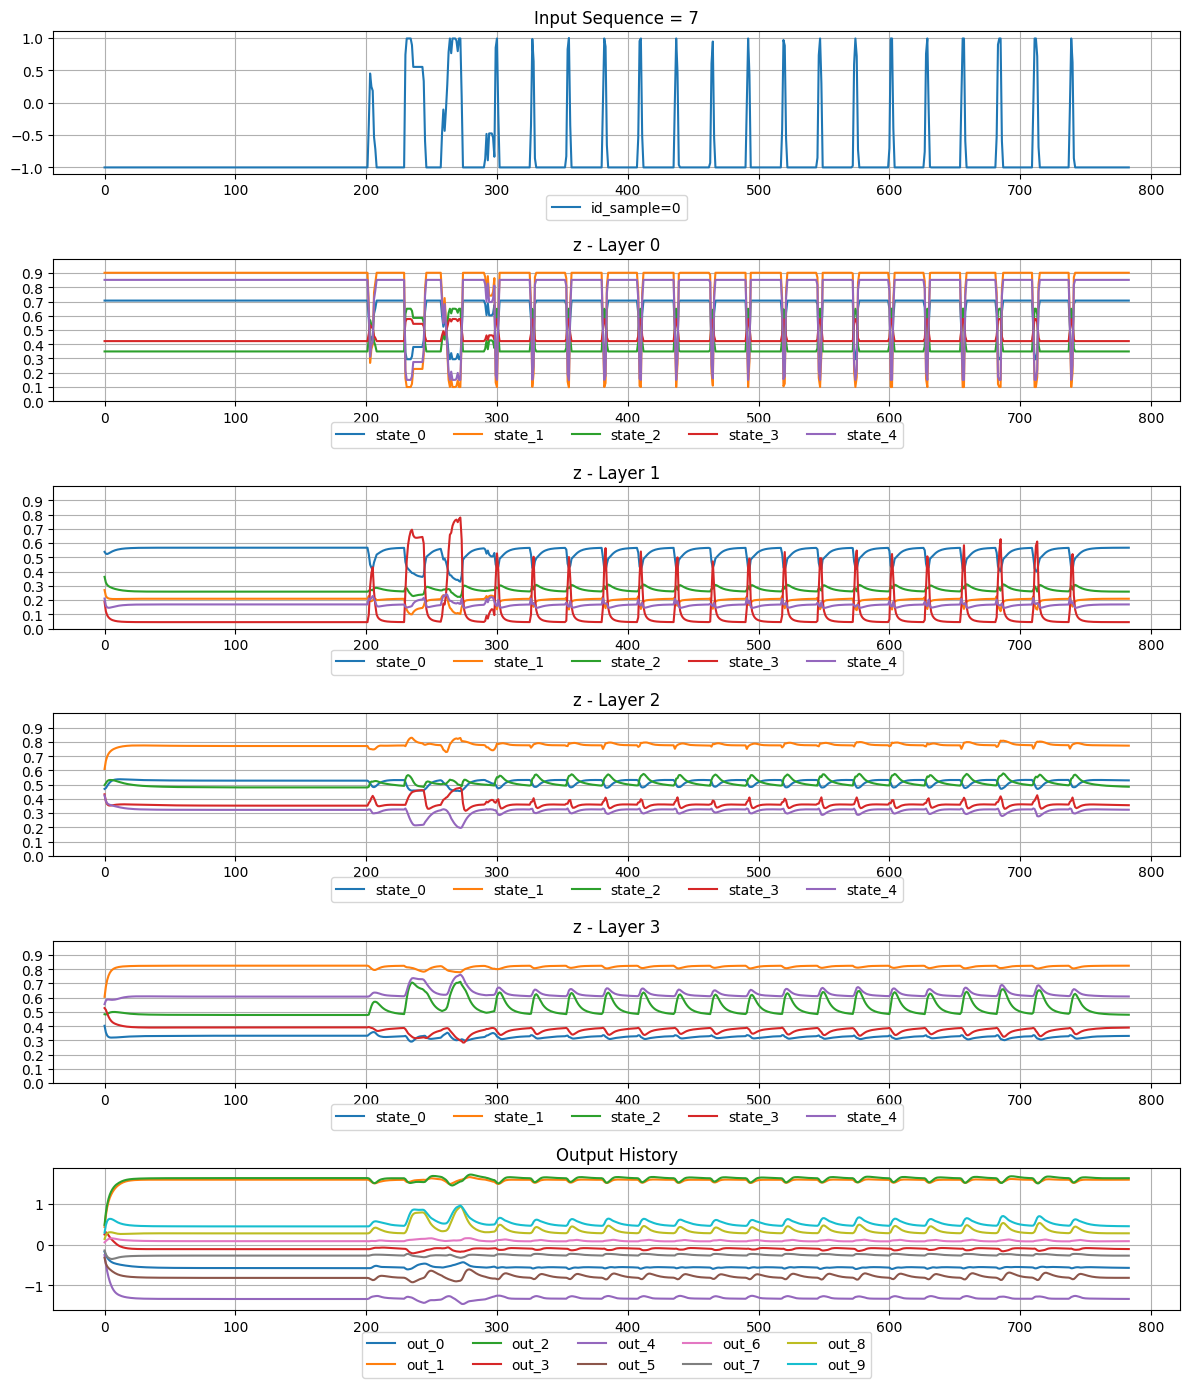

In [16]:
plot_dynamics(model, state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, 
              id_sample=0, model_type='mingru_heinsen', variable_to_plot='z')

In [17]:
N_EPOCHS = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
# 'batch_loss' = [loss_sample1, loss_sample2, ..., loss_sampleBS]
# 'loss' = [loss_batch1, loss_batch2, ..., loss_batchN] where N is the number of batches and loss_batchX = mean([loss_sample1, loss_sample2, ..., loss_sampleBS])
keys_to_track = ['grads', 'loss', 'state'] #['grads', 'loss', 'state', 'batch_x', 'batch_y'] # ['batch_x', 'batch_y', 'state', 'grads']
inner_keys_to_track = [] #['batch_loss', 'net_dyn']
aux_dict_training = []

for epoch in range(N_EPOCHS):
    key, subkey = jax.random.split(key) # not used in run_epoch (TODO: remove?)
    state, train_loss, train_accuracy, (break_flag, aux_dict_epoch) = run_epoch(state, trainloader, key, lim_batch=None, keys_to_track=keys_to_track, inner_keys_to_track=inner_keys_to_track)
    aux_dict_training.append(aux_dict_epoch)
    if break_flag:
        break
    val_loss, val_acc  = validate(state, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_accuracy*100:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc*100:.2f}%")

Training: 100%|██████████| 390/390 [00:13<00:00, 28.55it/s, accuracy=0.727, loss=0.8]  


Epoch 0 | train_loss: 1.7117 | train_acc: 39.97% | val_loss: 0.8235 | val_acc: 72.10%


Training: 100%|██████████| 390/390 [00:07<00:00, 50.62it/s, accuracy=0.828, loss=0.477]


Epoch 1 | train_loss: 0.6329 | train_acc: 78.94% | val_loss: 0.5184 | val_acc: 82.62%


Training: 100%|██████████| 390/390 [00:07<00:00, 50.53it/s, accuracy=0.836, loss=0.417]


Epoch 2 | train_loss: 0.4664 | train_acc: 84.74% | val_loss: 0.4617 | val_acc: 83.96%


Training:   9%|▊         | 34/390 [00:00<00:07, 48.88it/s, accuracy=0.883, loss=0.357]

NAN Loss


In [23]:
# how to write to a txt file
grads_hist = aux_dict_training[-1]['grads']
step_loss = aux_dict_training[-1]['loss']
with open('flax4b_minGRU_heinsen_grads.txt', 'w') as f:
    for i in range(len(aux_dict_training[-1]['grads'])):
        str_ = f'{jax.tree_util.tree_map(lambda x: round(float(jnp.max(jnp.abs(x))),2), grads_hist[i])}, {step_loss[i]}\n'
        f.write(str_)

In [28]:
bad_state = aux_dict_training[-1]['state'][-2]
print(bad_state)
state_hist, out_hist = bad_state.apply_fn({'params': bad_state.params}, batch_x)


TrainState(step=Array(1202, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of VmapRNNBackbone(
    # attributes
    hidden_size = 64
    output_size = 10
    n_layers = 4
    recurrent_layer = HeinsenMinGRULayer
)>, params={'Dense_Out': {'bias': Array([-0.   ,  0.004, -0.027, -0.   ,  0.024,  0.004,  0.016, -0.   ,
       -0.004, -0.007], dtype=float32), 'kernel': Array([[ 0.328,  0.107,  0.211,  0.07 , -0.335,  0.024,  0.137, -0.423,
         0.022, -0.368],
       [-0.347, -0.1  , -0.128,  0.259,  0.127,  0.116, -0.117, -0.041,
        -0.125, -0.137],
       [-0.143, -0.125,  0.015,  0.078,  0.079, -0.19 , -0.049, -0.103,
        -0.02 ,  0.213],
       [-0.199, -0.086,  0.17 ,  0.127, -0.114,  0.119,  0.04 , -0.062,
        -0.028,  0.188],
       [-0.048, -0.026,  0.01 ,  0.107,  0.045, -0.008, -0.016,  0.101,
         0.072, -0.102],
       [-0.22 , -0.235,  0.023, -0.202,  0.166, -0.281, -0.018,  0.022,
        -0.187,  0.082],
       [ 0.068,  0.247, -0.077, 

4
3
(5, 784, 64)


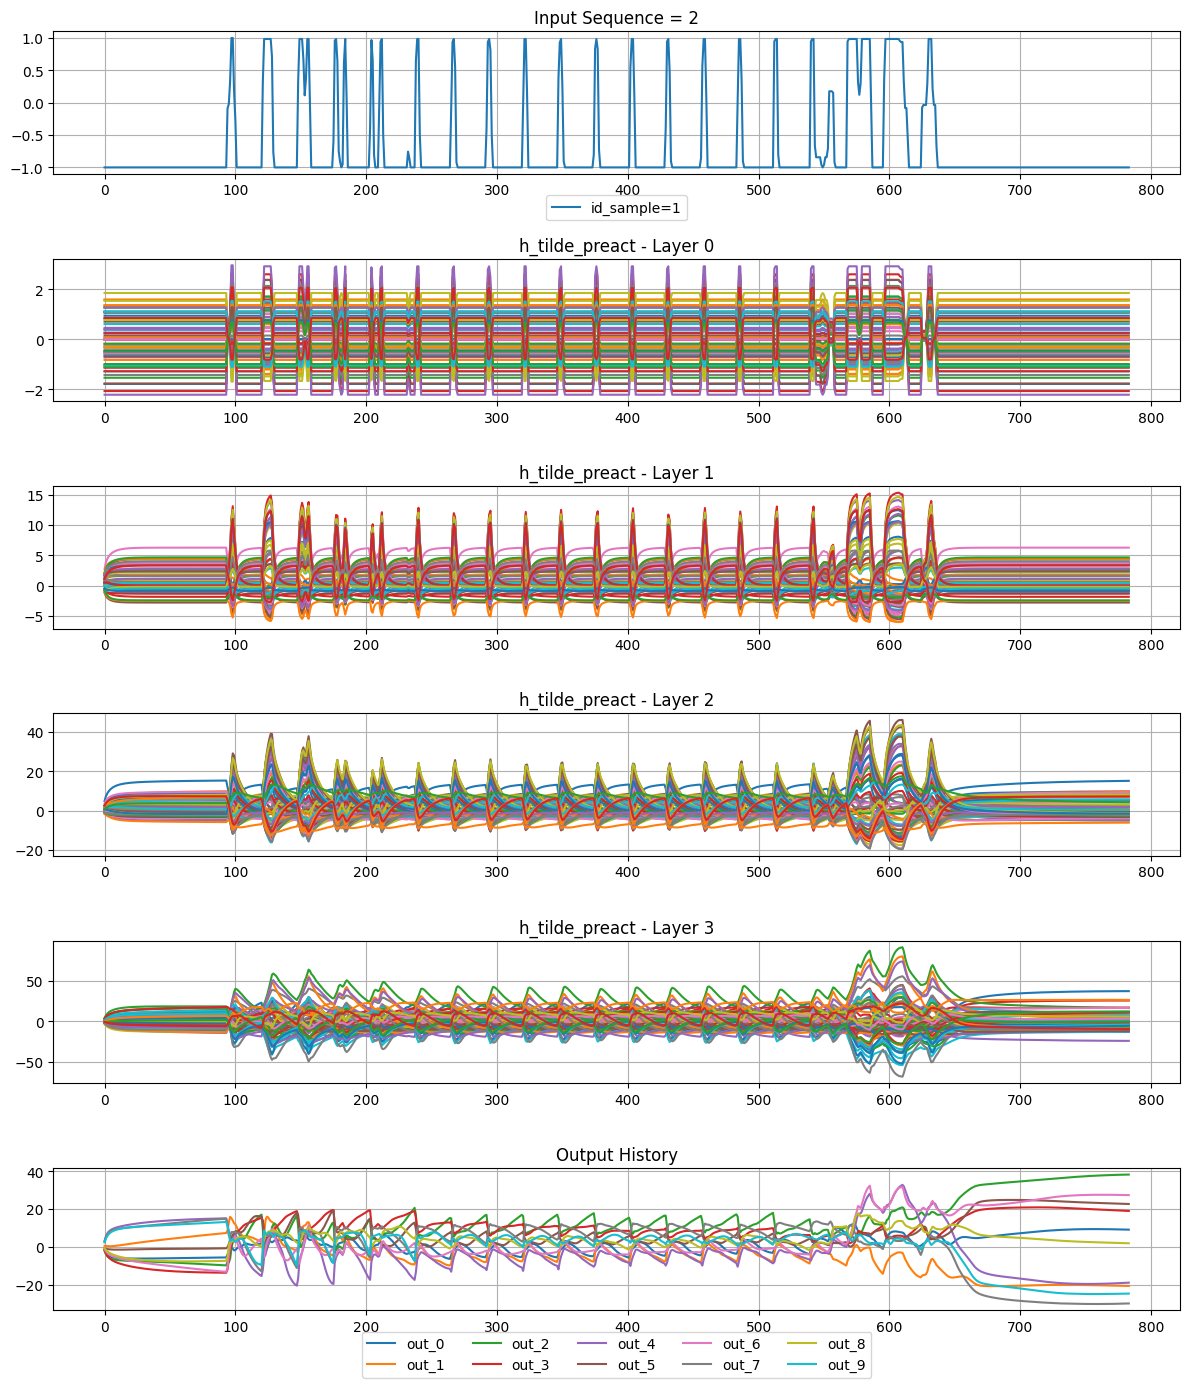

In [31]:
plot_dynamics(model, bad_state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, 
              id_sample=1, model_type='mingru_heinsen', variable_to_plot='h_tilde_preact', nb_components_to_plot=64, zoom=False)

print(len(aux))